In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt

In [2]:
# all parameters for generating the time series should be configured in this cell
periode = 5 #days
step = 10 # mess interval in minutes
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "number":3,
        "max_gain":2        
        },
    "Trend": {
        "number":2,
        "max_slope":0.01
        },
    "Seasonality": {
        "number":2,
        "frequency_range":(7, 14),
        "amplitude_range":(5, 20),
        }
    }

### Init Model
latent_dims = 3
L = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = vae(n_channels, L, latent_dims)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'T': 720, 'nchannels': 3, 'mu': array([[ 9.      ,  9.      ,  9.      , ..., 58.920467, 58.996105,
        59.07174 ],
       [20.0844  , 19.095224, 18.083141, ..., 15.      , 15.      ,
        15.160014],
       [64.      , 64.      , 64.      , ..., 45.841362, 45.144012,
        44.37221 ]], dtype=float32), 'cov': array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])}
{'Pulse': {'channel': [1, 0, 1], 'index': [4829, 1520, 1949], 'scale': [-1.207748540961504, 1.042122848795835, -1.3235566537498582]}, 'Trend': {'channel': [2, 0], 'index': [3435, 574], 'slope': [-0.009387666922546133, 0.007552298797946581]}, 'Seasonality': {'channel': [1, 2], 'frequency': [12.002030483783834, 10.79781057607883], 'amplitude': [14, 19], 'phaseshift': [141, 92]}}


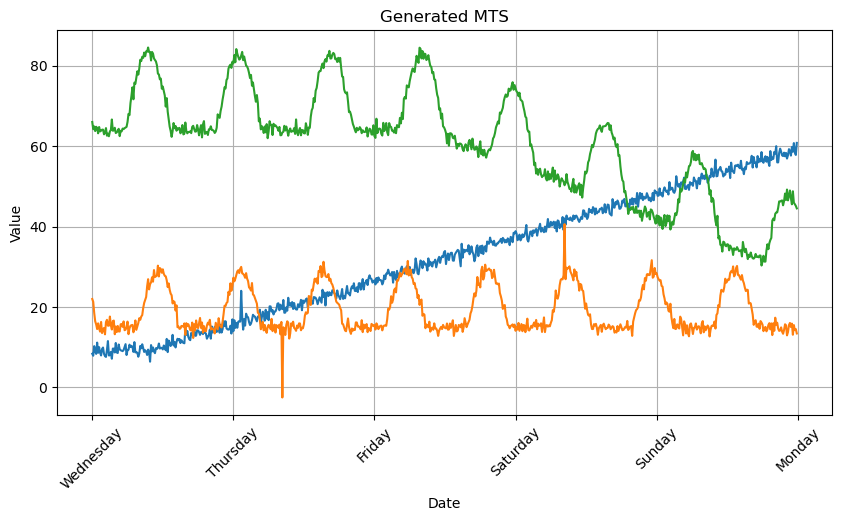

In [3]:
X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
print(params)
print(e_params)
X.show()

In [4]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

In [12]:
for epoch in range(1, 10):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/4770 (0%)]	Loss: 3666.488672
Train Epoch: 1 [1000/4770 (21%)]	Loss: 30.427652
Train Epoch: 1 [2000/4770 (42%)]	Loss: 26.733771
Train Epoch: 1 [3000/4770 (63%)]	Loss: 17.020352
Train Epoch: 1 [4000/4770 (84%)]	Loss: 33.416681
====> Epoch: 1 Average loss: 141.3348
Train Epoch: 2 [0/4770 (0%)]	Loss: 3670.216797
Train Epoch: 2 [1000/4770 (21%)]	Loss: 32.078802
Train Epoch: 2 [2000/4770 (42%)]	Loss: 18.364276
Train Epoch: 2 [3000/4770 (63%)]	Loss: 16.944164
Train Epoch: 2 [4000/4770 (84%)]	Loss: 41.167682
====> Epoch: 2 Average loss: 136.0990
Train Epoch: 3 [0/4770 (0%)]	Loss: 3935.441797
Train Epoch: 3 [1000/4770 (21%)]	Loss: 32.536053
Train Epoch: 3 [2000/4770 (42%)]	Loss: 30.400891
Train Epoch: 3 [3000/4770 (63%)]	Loss: 15.990796
Train Epoch: 3 [4000/4770 (84%)]	Loss: 44.379962
====> Epoch: 3 Average loss: 135.9844
Train Epoch: 4 [0/4770 (0%)]	Loss: 4023.033203
Train Epoch: 4 [1000/4770 (21%)]	Loss: 31.681161
Train Epoch: 4 [2000/4770 (42%)]	Loss: 31.502188
Train Epoch:

In [8]:
def compare(dataset, model):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            x_rec, mu, logvar = model(data)
            z = v.reparametrization_trick(mu, logvar)

            x.extend(data[:,:,0].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
        
    print(mu[-1, :], logvar[-1, :])
    plt.plot(rec, "r--")
    plt.plot(x[:-L], "b-")
    plt.ylim(0,100)
    plt.grid(True)
    
    return z[-1, :]

tensor([ 0.0846,  0.0712, -0.4662,  0.7484,  0.9439,  0.5821]) tensor([-1.2313, -1.1087, -4.9292, -0.9777, -3.5389, -0.7808])


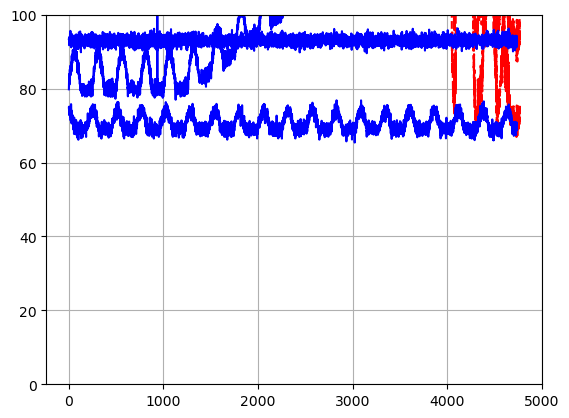

In [13]:
z = compare(train_data, v)

In [35]:
test(v, test_data, criterion, device)

====> Test set loss: 176.2198


1000


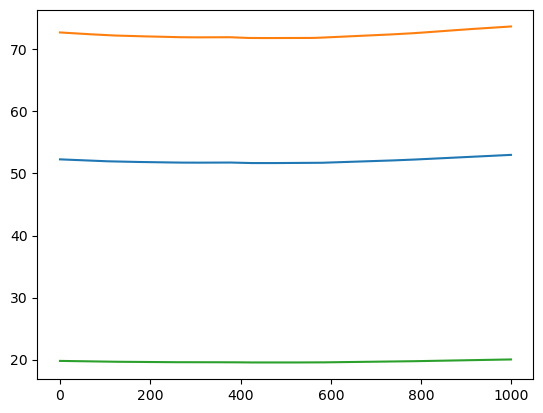

In [36]:
rec = []
for i in range(1000):
    z[16] = 0.01*i
    
    x_rec = v.decoder(z)

    rec.append(x_rec.detach().numpy())
print(len(rec))
plt.plot(rec)

In [37]:
z = np.arange(0.001,1, 0.01)
z

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991])

In [40]:
# %matplotlib 
# import ipywidgets as widgets

# z = np.arange(16)
# @interact(z, np.arange(0.001,10, 0.01))
def experiment(z,z_num):
    rec = []
    for i in range(1000):
        z[z_num] = 0.01*i

        x_rec = v.decoder(z)

        rec.append(x_rec.detach().numpy())
    print(len(rec))
    plt.plot(rec)
    
# widgets.interact(experiment, z)

1000


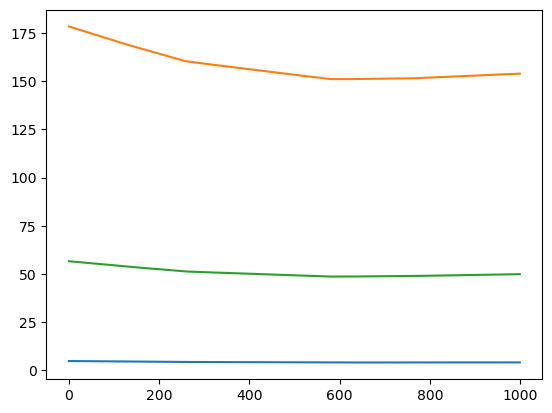

In [64]:
experiment(z,3)

In [ ]:
1) Pulse/ Rechteck
2) Trends (linear or not)
3) Periodicity
std. effects
5) coupling durch cov matrix
6) Noise
7) Effect of latent dim änderung, welche größe ist am besten  geeignet, soll latent_dim = n_channels sein? couploung durch hiarchie?
Modeling of interactions effects in die simulation hilft um die interpretation zu validieren, man kann die effecte aus der realen daten 
besser mathematisch verstehen
8) Short and long term effects durch die verschiedenen Convolutions weights"aktivierung von neuronen/ welche neuraonen sind mehr active in welche fälle"
idee is to know what layers capt long term effects and which layers capt short terms to be able to better interpret the data
9) also change the effects to be intern effects -> they happen on the level of mean and std rather than additif to the channels and let only be some random noise additif (y = x +epsilon)
all the rest (trends, seasonalities, pulses should happen on the level of mean and std)


Write and document all the steps I wanna do and make check list
try to make the data scales and dimention real (x axes represents tims -> days, hours, secs / are the seasonalities daily or weekly etc)

In [4]:
60/5

12.0

In [5]:
12*24

288

In [6]:
288*7

2016

In [7]:
2016*4

8064

In [8]:
60*24

1440